In [1]:
import numpy as np
import pandas as pd
import open3d as o3d
import pymeshlab as pyml
import time 
import os
import trimesh


import matplotlib.pyplot as plt
import seaborn as sns


import pclpy
from pclpy import pcl
from plyfile import PlyData, PlyElement,PlyProperty, PlyListProperty


In [2]:
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", 2000)
pd.set_option("display.max_colwidth", 256)

In [3]:
%matplotlib inline
sns.set(rc={'figure.figsize':(8,6)})


In [4]:
os.chdir("D:\\Workspace\\Python\\Thesis Data\\")

In [5]:
# NOTE CHECK THIS PATH FIRST
INPUT_PATH = os.getcwd()+'\\Save data\\Processed_data'
OUTPUT_TEMP_PATH = os.getcwd()+'\\Save data\\Processed_data\\Output_temp'

INPUT_TEMP_PATH = os.getcwd()+'\\Save data\\Processed_data\\Output_temp'
OUTPUT_PATH = os.getcwd()+'\\Save data\\Processed_data\\Output'

OUTPUT_PCA_PATH = os.getcwd()+'\\Save data\\Processed_data\\Output\\PCA'


In [6]:
ORIGINAL_FILENAME = "_PLY0.ply"
WSS_FILENAME = "_WSS.csv"
WSS_DOWN_FILENME = "_WSS_down.csv"
CURV_FILENAME = "_curv_down.csv"

PYMESH_FILENAME = "_pymesh.ply"
DESC_1_FILENAME = "_fpfh.ply"
DESC_2_FILENAME = "_shot.ply"

RADIUS_SEARCH = 0.00024
RADIUS = RADIUS_SEARCH * 0.6

OUTPUT_FILENAME = "_output.ply"
os.path.join(OUTPUT_TEMP_PATH,f"{ORIGINAL_FILENAME}{PYMESH_FILENAME}")

'D:\\Workspace\\Python\\Thesis Data\\Save data\\Processed_data\\Output_temp\\_PLY0.ply_pymesh.ply'

In [7]:
def get_total_runtime(start, end):
    temp = end-start
    print("Total seconds = %d" %temp)
    hours = temp//3600
    temp = temp - 3600*hours
    minutes = temp//60
    seconds = temp - 60*minutes
    print('%d hrs %d mins %d secs' %(hours,minutes,seconds))

## 1. Cleaning and Downsampling
##### Using Meshlab

In [111]:
ms = pyml.MeshSet()

TARGET_FACE_COUNT = 35000

PATIENT_ID = '70_HI'
ms.load_new_mesh(os.path.join(INPUT_PATH,f"{PATIENT_ID}{ORIGINAL_FILENAME}"))
ms.apply_filter('repair_non_manifold_edges_by_removing_faces')
ms.apply_filter('laplacian_smooth')
ms.apply_filter('simplification_quadric_edge_collapse_decimation',targetfacenum  = TARGET_FACE_COUNT, preserveboundary= True,
               preservenormal = True, preservetopology = True)

# ms.save_current_mesh(os.path.join(path,"bm_pymesh.ply"),format = 'ascii' )
# ms.save_current_mesh(os.path.join(OUTPUT_TEMP_PATH,f"{PATIENT_ID}_binary{PYMESH_FILENAME}") )

{}

#### Convert BINARY to ASCII

In [6]:
from plyfile import PlyData, PlyElement

In [7]:
plydata = PlyData.read(os.path.join(OUTPUT_TEMP_PATH,f"{PATIENT_ID}_binary{PYMESH_FILENAME}"))

In [8]:
pl_wr = PlyData(plydata.elements, text = True, comments = ['PLYFILE BINARY TO ASCII CONVERTED'])
pl_wr.write(os.path.join(OUTPUT_TEMP_PATH,f"{PATIENT_ID}{PYMESH_FILENAME}"))

## 2. Compute Curvature Features

### 2.1 Adjust RADIUS SEARCH - Using nearest distance between points

In [5]:
#LOAD Point Cloud in o3d instance
pc_o3d = o3d.io.read_point_cloud(os.path.join(OUTPUT_TEMP_PATH,f"{PATIENT_ID}_gui{PYMESH_FILENAME}"))

#Compute nearest distance
NN_dist = pc_o3d.compute_nearest_neighbor_distance()
pd.Series(NN_dist).describe()

count    17618.000000
mean         0.000227
std          0.000067
min          0.000048
25%          0.000178
50%          0.000221
75%          0.000269
max          0.000558
dtype: float64

In [6]:
np.argmin(np.array(NN_dist)), np.argmax(np.array(NN_dist))

(7773, 15353)

In [81]:
RADIUS_SEARCH = 0.0005
RADIUS_MULTIPLIER = 1.2
if RADIUS_SEARCH < np.max(NN_dist)* RADIUS_MULTIPLIER:
    RADIUS_SEARCH = np.max(NN_dist) * RADIUS_MULTIPLIER
    RADIUS_SEARCH = np.around(RADIUS_SEARCH,decimals = 4)

        
print(f"Min dist = {np.min(NN_dist)} , Current Search Radius = {RADIUS_SEARCH}")

Min dist = 4.787268218932541e-05 , Current Search Radius = 0.0007


In [89]:
#Build tree
# RADIUS_SEARCH = 0.0005
o3d_kdtree = o3d.geometry.KDTreeFlann(pc_o3d)

# Radius search 
search_pt = pc_o3d.points[np.argmin(np.array(NN_dist))]
# search_pt = [ 0.02097408,  0.0077485 , -0.0230285 ]
[k, idx, _] = o3d_kdtree.search_radius_vector_3d(search_pt, RADIUS_SEARCH)
idx

IntVector[7773, 7775, 7776, 7781, 7791, 7766, 7777, 7779, 7792, 7780, 7774, 7805, 7806]

In [38]:
np.asarray(pc_o3d.points)[7773,:]

array([ 0.02259422,  0.01082676, -0.01030684])

### 2.2 Compute Gaussian & Mean curvature using Radius

In [45]:
#Load Mesh in Trimesh object
tr_mesh = trimesh.load(os.path.join(OUTPUT_TEMP_PATH,f"{PATIENT_ID}{PYMESH_FILENAME}"))

In [46]:
tr_mesh.vertices

TrackedArray([[ 0.02229504, -0.00542205, -0.02096887],
              [ 0.02296576,  0.01063704, -0.01445156],
              [ 0.02363392, -0.00493844, -0.0233873 ],
              ...,
              [ 0.01569023,  0.00280903, -0.02975548],
              [ 0.02031615,  0.00981753, -0.00210714],
              [ 0.02228223,  0.00731912, -0.02242908]])

In [47]:
#Create a df with x,y,z points for storing curvature values

curv_df = pd.DataFrame(data =tr_mesh.vertices , columns = ["Points:0", "Points:1", "Points:2"])
curv_df.head(2)

,Points:0,Points:1,Points:2
0,0.022295,-0.005422,-0.020969
1,0.022966,0.010637,-0.014452


##### Compute curvature using RADIUS_SEARCH as radius

#### Normalize Std by dividing with mean - CV
https://math.stackexchange.com/questions/260617/how-to-determine-if-standard-deviation-is-high-low

#### 

In [48]:
# tr_mesh = trimesh.load(os.path.join(OUTPUT_TEMP_PATH,f"{PATIENT_ID}{PYMESH_FILENAME}"))

gaus_curv = trimesh.curvature.discrete_mean_curvature_measure(mesh = tr_mesh, points = tr_mesh.vertices, 
                                                              radius =  RADIUS_SEARCH)


In [53]:
gaus_curv2 = trimesh.curvature.discrete_mean_curvature_measure(mesh = tr_mesh, points = tr_mesh.vertices, 
                                                              radius =  RADIUS_SEARCH*0.5)


In [56]:
gaus_curv3 = trimesh.curvature.discrete_mean_curvature_measure(mesh = tr_mesh, points = tr_mesh.vertices, 
                                                              radius =  RADIUS_SEARCH*1.2)


In [69]:
gaus_curv4 = trimesh.curvature.discrete_mean_curvature_measure(mesh = tr_mesh, points = tr_mesh.vertices, 
                                                              radius =  RADIUS_SEARCH*1.5)


In [50]:
pd.Series(gaus_curv*1000).describe()

count    17826.000000
mean         0.640598
std          0.598329
min         -1.924249
25%          0.289993
50%          0.511304
75%          0.881737
max          3.792162
dtype: float64

In [70]:
 np.std(gaus_curv)/np.mean(gaus_curv),  np.std(gaus_curv2)/np.mean(gaus_curv2),  np.std(gaus_curv3)/np.mean(gaus_curv3),  np.std(gaus_curv4)/np.mean(gaus_curv4)


(0.9339902089387081,
 1.0303542493040958,
 0.9206635405481846,
 0.8921122064545164)

In [61]:
np.std(gaus_curv)/(np.max(gaus_curv)-np.min(gaus_curv)) 

0.10466569734980725

In [65]:
np.std(gaus_curv2)/(np.max(gaus_curv2)-np.min(gaus_curv2)), np.std(gaus_curv3)/(np.max(gaus_curv3) - np.min(gaus_curv3)) 

(0.08363800245975958, 0.12108731557949243)

In [71]:
np.std(gaus_curv4)/(np.max(gaus_curv4)-np.min(gaus_curv4)),

(0.14809834846655115,)

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

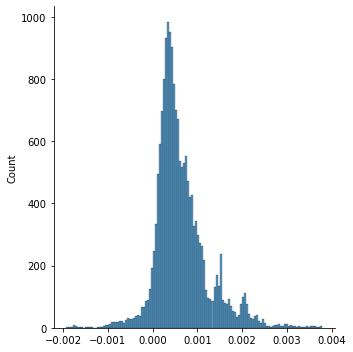

In [52]:
sns.displot(pd.Series(gaus_curv))

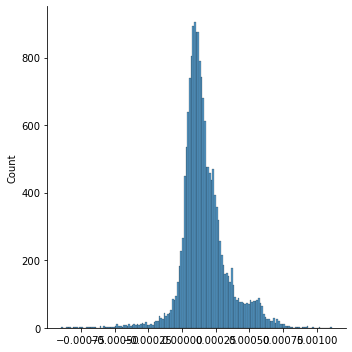

In [55]:
sns.displot(pd.Series(gaus_curv2))

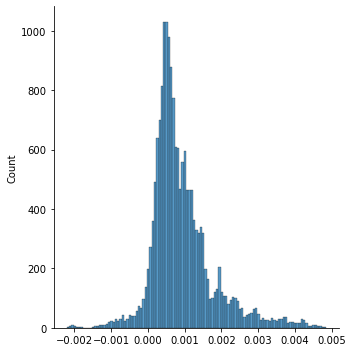

In [58]:
sns.displot(pd.Series(gaus_curv3))

In [32]:
import trimesh
from trimesh.curvature import discrete_gaussian_curvature_measure, discrete_mean_curvature_measure, sphere_ball_intersection
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

mesh = trimesh.creation.icosphere()

In [37]:

radii = np.linspace(0.1, 2.0, 10)
# gauss = np.array([discrete_gaussian_curvature_measure(mesh, mesh.vertices, r)/sphere_ball_intersection(1, r) for r in radii])
mean = np.array([discrete_mean_curvature_measure(mesh, mesh.vertices, r)/sphere_ball_intersection(1, r) for r in radii])

In [41]:
mesh.vertices.shape

(642, 3)

In [42]:
mean.shape

(10, 642)

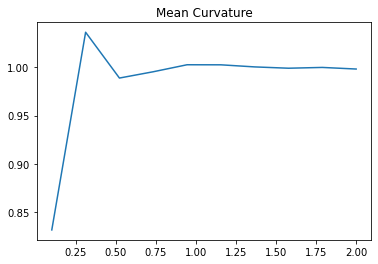

In [38]:
plt.figure()
plt.plot(radii, mean.mean(axis=1))
plt.title('Mean Curvature')
plt.show();

In [441]:
from plyfile import PlyProperty
P_ID = '8_BP'

p = PlyData.read(os.path.join(OUTPUT_TEMP_PATH,f"{P_ID}{PYMESH_FILENAME}"), mmap=False)

p.elements[0].properties = (PlyProperty('x', 'f4'), PlyProperty('y', 'f4'), PlyProperty('z', 'f4'))
p.elements[0].properties

(PlyProperty('x', 'float'),
 PlyProperty('y', 'float'),
 PlyProperty('z', 'float'))

In [442]:
pl_wr = PlyData(p.elements, text = True, comments = ['PLYFILE BINARY TO ASCII CONVERTED'])
pl_wr.write(os.path.join(OUTPUT_TEMP_PATH,f"{P_ID}_trial{PYMESH_FILENAME}"))

In [449]:
for P_ID in patient_id_list:
    print(f"\nProcessing File at:")
    print(os.path.join(OUTPUT_TEMP_PATH,f"{P_ID}{PYMESH_FILENAME}"))
    
    p = PlyData.read(os.path.join(OUTPUT_TEMP_PATH,f"{P_ID}{PYMESH_FILENAME}"), mmap=False)
    p.elements[0].properties = (PlyProperty('x', 'f4'), PlyProperty('y', 'f4'), PlyProperty('z', 'f4'))
    pl_wr = PlyData(p.elements, text = True, comments = ['PLYFILE BINARY TO ASCII CONVERTED IN float32'])
    pl_wr.write(os.path.join(OUTPUT_TEMP_PATH,f"{P_ID}{PYMESH_FILENAME}"))


Processing File at:
D:\Workspace\Python\Thesis Data\Save data\Processed_data\Output_temp\2_BC_pymesh.ply

Processing File at:
D:\Workspace\Python\Thesis Data\Save data\Processed_data\Output_temp\3_BC_pymesh.ply

Processing File at:
D:\Workspace\Python\Thesis Data\Save data\Processed_data\Output_temp\4_BC_pymesh.ply

Processing File at:
D:\Workspace\Python\Thesis Data\Save data\Processed_data\Output_temp\5_BM_pymesh.ply

Processing File at:
D:\Workspace\Python\Thesis Data\Save data\Processed_data\Output_temp\6_BM_pymesh.ply

Processing File at:
D:\Workspace\Python\Thesis Data\Save data\Processed_data\Output_temp\7_BP_pymesh.ply

Processing File at:
D:\Workspace\Python\Thesis Data\Save data\Processed_data\Output_temp\8_BP_pymesh.ply

Processing File at:
D:\Workspace\Python\Thesis Data\Save data\Processed_data\Output_temp\9_KBW_pymesh.ply

Processing File at:
D:\Workspace\Python\Thesis Data\Save data\Processed_data\Output_temp\10_SUM_pymesh.ply

Processing File at:
D:\Workspace\Python\Th

In [443]:
# RADIUS_SEARCH = RADIUS_SEARCH*0.5
RADIUS_SEARCH = 0.00024
RADIUS_SEARCH

0.00024

In [469]:
#Build tree
P_ID = '8_BP'
# RADIUS_SEARCH = 0.0005
# RADIUS_SEARCH = 1.1*np.max(NN_dist)
# RADIUS_SEARCH = RADIUS_SEARCH*0.5
pc_o3d =  o3d.io.read_point_cloud(os.path.join(OUTPUT_TEMP_PATH,f"{P_ID}{PYMESH_FILENAME}"))
o3d_kdtree = o3d.geometry.KDTreeFlann(pc_o3d)

# Radius search 
search_pt_min = pc_o3d.points[np.argmin(np.array(NN_dist))]
search_pt_max = pc_o3d.points[np.argmax(np.array(NN_dist))]

# search_pt = [ 0.02097408,  0.0077485 , -0.0230285 ]
[k_min, idx_min, _] = o3d_kdtree.search_radius_vector_3d(search_pt_min, RADIUS_SEARCH)
[k_max, idx_max, _] = o3d_kdtree.search_radius_vector_3d(search_pt_max, RADIUS_SEARCH)

k_min, k_max

(8, 7)

In [470]:
P_ID = '32_JM'
pcl_obj = pclpy.pcl.PointCloud.PointXYZ()
# pc = pcl.io.loadPLYFile(file_name = os.path.join(OUTPUT_TEMP_PATH,f"{P_ID}_trial{PYMESH_FILENAME}"), cloud = pcl_obj, )
pc = pcl.io.loadPLYFile(file_name = os.path.join(OUTPUT_TEMP_PATH,f"{P_ID}{PYMESH_FILENAME}"), cloud = pcl_obj, )
# pc = pcl.io.loadPLYFile(file_name = os.path.join(INPUT_PATH,f"{P_ID}{ORIGINAL_FILENAME}"), cloud = pcl_obj, )


In [471]:
RADIUS_SEARCH = 0.00024
# RADIUS_SEARCH = RADIUS_SEARCH*0.8

RADIUS = RADIUS_SEARCH * 0.6

start = time.time()

data_normals = pcl_obj.compute_normals(radius=RADIUS, num_threads=8)

end = time.time()

get_total_runtime(start,end)

Total seconds = 0
0 hrs 0 mins 0 secs


In [472]:

start = time.time()

fpfh = pcl.features.FPFHEstimation.PointXYZ_Normal_FPFHSignature33()

fpfh.setInputCloud(cloud = pcl_obj)
fpfh.setInputNormals(data_normals)
fpfh.setRadiusSearch(RADIUS_SEARCH)

fpfhs = pcl.PointCloud.FPFHSignature33()
fpfh.compute(fpfhs)
end = time.time()

get_total_runtime(start,end)

Total seconds = 0
0 hrs 0 mins 0 secs


In [473]:
fpfhs.histogram 

array([[ 2.921555  ,  3.2470186 ,  5.613363  , ...,  9.459003  ,
        10.155712  ,  6.9719415 ],
       [ 9.748515  ,  4.1553817 ,  7.3651676 , ...,  4.6441183 ,
         7.1431336 , 10.211701  ],
       [ 4.386112  ,  5.4585695 ,  7.6715226 , ...,  7.6200686 ,
        10.704243  , 13.77321   ],
       ...,
       [12.231748  ,  2.6281629 ,  0.9175767 , ..., 19.804995  ,
         0.8747178 ,  0.42658424],
       [11.897634  ,  1.5109129 ,  0.6436358 , ...,  8.514689  ,
         0.6531307 ,  0.32470417],
       [14.515498  ,  3.2876534 ,  0.53388983, ..., 18.427965  ,
         0.45441782,  0.2262915 ]], dtype=float32)

In [361]:
pcl.io.savePLYFileASCII(file_name = os.path.join(OUTPUT_TEMP_PATH,f"{P_ID}{DESC_1_FILENAME}"), cloud = fpfhs)

0

### Get WSS values

In [8]:
INPUT_PATH = os.getcwd()+'\\Save data\\Processed_data'
OUTPUT_TEMP_PATH = os.getcwd()+'\\Save data\\Processed_data\\Output_temp'

INPUT_TEMP_PATH = os.getcwd()+'\\Save data\\Processed_data\\Output_temp'
OUTPUT_PATH = os.getcwd()+'\\Save data\\Processed_data\\Output'


In [9]:
ORIGINAL_FILENAME = "_PLY0.ply"
WSS_FILENAME = "_WSS.csv"
WSS_DOWN_FILENME = "_WSS_down.csv"
CURV_FILENAME = "_curv_down.csv"

PYMESH_FILENAME = "_pymesh.ply"
DESC_1_FILENAME = "_fpfh.ply"
DESC_2_FILENAME = "_shot.ply"

RADIUS_SEARCH = 0.00024
RADIUS = RADIUS_SEARCH * 0.6

OUTPUT_FILENAME = "_output.ply"
os.path.join(OUTPUT_TEMP_PATH,f"{ORIGINAL_FILENAME}{PYMESH_FILENAME}")

'D:\\Workspace\\Python\\Thesis Data\\Save data\\Processed_data\\Output_temp\\_PLY0.ply_pymesh.ply'

In [10]:
patient_id_list = '2_BC	3_BC	4_BC	5_BM	6_BM	7_BP	8_BP	9_KBW	10_SUM	11_DHM	12_GAW	13_PMM	14_TR	15_TR	16_TR	18_EM	19_EM	20_EM	21_FA	22_FA	23_HJ	24_HJ	25_HM	26_HM	27_HM	28_JM	29_JM	30_JM	31_JM	32_JM	33_KBB	34_KBB	35_KBB	36_KBB	37_KBB	38_KBB	39_KBB	40_KBB	41_KBB	42_KBB	43_KBB	44_AC	45_AC	46_LE	47_LE	48_LE	49_LE	50_LE	51_LE	52_LE	53_LS	54_MR	55_MR	56_WA	57_SF	58_SI	59_SI'
patient_id_list = patient_id_list.split()
patient_id_list[:5]

['2_BC', '3_BC', '4_BC', '5_BM', '6_BM']

### 2.1 Check Radius for different dataset files

In [256]:
radius_columns = ['original_points','sampled_points','radius_mean','radius_median','radius_std','radius_min','radius_max',]
radius_df = pd.DataFrame(index=patient_id_list, columns = radius_columns )
radius_df.head(2)

,original_points,sampled_points,radius_mean,radius_median,radius_std,radius_min,radius_max
2_BC,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3_BC,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [257]:
for PATIENT_ID in patient_id_list:

    #LOAD Point Cloud in o3d instance
    pc_original = o3d.io.read_point_cloud(os.path.join(INPUT_PATH,f"{PATIENT_ID}{ORIGINAL_FILENAME}"))
    pc_o3d = o3d.io.read_point_cloud(os.path.join(OUTPUT_TEMP_PATH,f"{PATIENT_ID}{PYMESH_FILENAME}"))

    #Compute nearest distance
    NN_dist = pc_o3d.compute_nearest_neighbor_distance()
    
    radius_df.loc[PATIENT_ID] = [len(np.asarray(pc_original.points)),len(np.asarray(pc_o3d.points)), 
                          np.mean(NN_dist), np.median(NN_dist), np.std(NN_dist), np.min(NN_dist), np.max(NN_dist)
                         ]

# df = df.astype(float)
radius_df = radius_df.infer_objects()
# pd.to_numeric(df, downcast='float')
radius_df.head(5)

,original_points,sampled_points,radius_mean,radius_median,radius_std,radius_min,radius_max
2_BC,77127,15307,0.000114,0.000114,0.000026,0.000011,0.000245
3_BC,28274,15271,0.000119,0.000117,0.000026,0.000014,0.000244
4_BC,22604,15223,0.000110,0.000103,0.000019,0.000030,0.000222
5_BM,95358,15366,0.000176,0.000173,0.000057,0.000033,0.000480
6_BM,20744,15154,0.000087,0.000084,0.000017,0.000033,0.000179


In [12]:
print (f"TOTAL FILES TO BE PROCESSED: {len(patient_id_list)}")

TOTAL FILES TO BE PROCESSED: 57


In [258]:
wss_columns = ['original_points','sampled_points','wss_mean','wss_median','wss_std','wss_min','wss_max',]
wss_eda = pd.DataFrame(index=patient_id_list, columns = wss_columns )
wss_eda.head(2)

,original_points,sampled_points,wss_mean,wss_median,wss_std,wss_min,wss_max
2_BC,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3_BC,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [259]:
for PATIENT_ID in patient_id_list:
    print(f"\nProcessing File at:")
    print(os.path.join(INPUT_PATH,f"{PATIENT_ID}{ORIGINAL_FILENAME}"))
    
    df_wss= pd.read_csv(os.path.join(INPUT_PATH,f"{PATIENT_ID}{WSS_FILENAME}"))
    
    wss_eda.loc[PATIENT_ID] = [df_wss.shape[0],np.nan, 
                          np.mean(df_wss.WSS), np.median(df_wss.WSS), np.std(df_wss.WSS), np.min(df_wss.WSS), np.max(df_wss.WSS)
                         ]
wss_eda = wss_eda.infer_objects()
wss_eda.head()


Processing File at:
D:\Workspace\Python\Thesis Data\Save data\Processed_data\2_BC_PLY0.ply

Processing File at:
D:\Workspace\Python\Thesis Data\Save data\Processed_data\3_BC_PLY0.ply

Processing File at:
D:\Workspace\Python\Thesis Data\Save data\Processed_data\4_BC_PLY0.ply

Processing File at:
D:\Workspace\Python\Thesis Data\Save data\Processed_data\5_BM_PLY0.ply

Processing File at:
D:\Workspace\Python\Thesis Data\Save data\Processed_data\6_BM_PLY0.ply

Processing File at:
D:\Workspace\Python\Thesis Data\Save data\Processed_data\7_BP_PLY0.ply

Processing File at:
D:\Workspace\Python\Thesis Data\Save data\Processed_data\8_BP_PLY0.ply

Processing File at:
D:\Workspace\Python\Thesis Data\Save data\Processed_data\9_KBW_PLY0.ply

Processing File at:
D:\Workspace\Python\Thesis Data\Save data\Processed_data\10_SUM_PLY0.ply

Processing File at:
D:\Workspace\Python\Thesis Data\Save data\Processed_data\11_DHM_PLY0.ply

Processing File at:
D:\Workspace\Python\Thesis Data\Save data\Processed_da

,original_points,sampled_points,wss_mean,wss_median,wss_std,wss_min,wss_max
2_BC,77127,NaN,2.664416,1.991029,2.601829,0.000063,21.984079
3_BC,28274,NaN,7.343544,7.063340,4.074379,0.073806,31.608334
4_BC,22604,NaN,7.312326,7.512783,2.861085,0.083918,24.377111
5_BM,95358,NaN,9.055627,5.069889,9.886064,0.005298,91.338405
6_BM,20744,NaN,6.449848,4.178266,6.059387,0.007637,36.123463


In [52]:
#Read Downsampled point cloud
pc_o3d =  o3d.io.read_point_cloud(os.path.join(INPUT_PATH,f"{P_ID}{ORIGINAL_FILENAME}"))

#Build tree for original point cloud
o3d_kdtree = o3d.geometry.KDTreeFlann(pc_o3d)

# Radius search 
# RADIUS_SEARCH = np.around(radius_df.describe().radius_max["50%"],decimals = 5)
RADIUS_SEARCH = 0.00022

search_pt = [0.013236, -0.001791, -0.030957]
search_pt_min = pc_o3d.points[np.argmin(np.array(NN_dist))]
search_pt_max = pc_o3d.points[np.argmax(np.array(NN_dist))]

[k, idx, _] = o3d_kdtree.search_radius_vector_3d(search_pt, RADIUS_SEARCH)
[k_min, idx_min, _] = o3d_kdtree.search_radius_vector_3d(search_pt_min, RADIUS_SEARCH)
[k_max, idx_max, _] = o3d_kdtree.search_radius_vector_3d(search_pt_max, RADIUS_SEARCH)

print(f"\nTotal neighbourhood points for the point with:\nquery_pt = {k} \nmin dist = {k_min} \nmax dist = {k_max}")


Total neighbourhood points for the point with:
query_pt = 18 
min dist = 15 
max dist = 19


In [238]:
#Read original file with WSS
P_ID = "6_BM"
df_wss= pd.read_csv(os.path.join(INPUT_PATH,f"{P_ID}{WSS_FILENAME}"))
df_wss = np.around(df_wss,8).copy()
df_wss.head(10)

,Points:0,Points:1,Points:2,WSS
0,0.024208,0.004076,-0.039114,4.288975
1,0.024192,0.004066,-0.039029,4.136771
2,0.024172,0.004139,-0.039025,3.999412
3,0.024187,0.004149,-0.039110,4.162654
4,0.026485,0.005572,-0.037911,1.614518
5,0.026556,0.005560,-0.037873,1.622992
6,0.026588,0.005560,-0.037956,1.328126
7,0.026517,0.005572,-0.037994,1.268355
8,0.025933,0.003472,-0.034352,6.098747
9,0.025986,0.003496,-0.034291,6.492345


In [260]:
#REMOVE PATIENT_IDS WHICH ARE OUTLIERS
patient_id_list_new = [x for x in patient_id_list if x not in wss_eda.query("wss_std >= 40").index.values]

In [264]:
for PATIENT_ID in patient_id_list_new[16:30]:
    print(f"\nProcessing File at:")
    print(os.path.join(INPUT_PATH,f"{PATIENT_ID}{ORIGINAL_FILENAME}"))
    
    start = time.time()

    #Read original file with WSS
    df_wss= pd.read_csv(os.path.join(INPUT_PATH,f"{PATIENT_ID}{WSS_FILENAME}"))
    #Round the points
    df_wss = np.around(df_wss,8).copy()
    
    #Create a df to save the files
    columns_wss_downsampled = ['x','y','z','WSS']
    df_wss_downsampled = pd.DataFrame(columns = columns_wss_downsampled )

    #Read Original and Downsampled point cloud
    pc_org = o3d.io.read_point_cloud(os.path.join(INPUT_PATH,f"{PATIENT_ID}{ORIGINAL_FILENAME}"))
    pc_down = o3d.io.read_point_cloud(os.path.join(OUTPUT_TEMP_PATH,f"{PATIENT_ID}{PYMESH_FILENAME}"))

    #Build tree for original point cloud
    kdtree_org = o3d.geometry.KDTreeFlann(pc_org)

    # Radius search 
#     RADIUS_SEARCH = np.around(radius_df.describe().radius_max["50%"],decimals = 5)
#     RADIUS_SEARCH = 0.00022

    for i in range(np.array(pc_down.points).shape[0]):
#     for i in range(10):

        search_pt = np.around(np.array(pc_down.points)[i], decimals = 8) 
        [k_org, idx_org, _] = kdtree_org.search_radius_vector_3d(search_pt, RADIUS_SEARCH)

        #Get Neighbourhood points and round them for avoiding issue with merge
        neighbour_pts = np.around(np.array(pc_org.points)[idx_org],decimals = 8)
        # Convert into a df - for merging
        neighbour_df = pd.DataFrame(neighbour_pts, columns = df_wss.columns.values[:3] )

        #Get the WSS column for the neighbourhood points 
        neighbour_df = neighbour_df.merge(df_wss, on = ['Points:0', 'Points:1', 'Points:2'], how='inner' )

        tempDF = pd.DataFrame(data = np.array([[search_pt[0],search_pt[1],search_pt[2],np.median(neighbour_df.WSS)]]),
                              columns = columns_wss_downsampled )
        df_wss_downsampled = pd.concat([df_wss_downsampled,tempDF],ignore_index=True)

    end = time.time()

    get_total_runtime(start,end) 
    
    #Round up the file to clean it.
    df_wss_downsampled = np.around(df_wss_downsampled,8)
    #Save the csv file
    df_wss_downsampled.to_csv(os.path.join(OUTPUT_TEMP_PATH,f"{PATIENT_ID}{WSS_DOWN_FILENME}"))


Processing File at:
D:\Workspace\Python\Thesis Data\Save data\Processed_data\19_EM_PLY0.ply
Total seconds = 1824
0 hrs 30 mins 24 secs

Processing File at:
D:\Workspace\Python\Thesis Data\Save data\Processed_data\20_EM_PLY0.ply


KeyboardInterrupt: 

In [16]:
rng = np.random.RandomState(0)
n_points = 4_000_000
d_dimensions = 4
k_neighbours = 3

X = rng.random_sample((n_points, d_dimensions))
X.shape

(4000000, 4)

In [20]:
from scipy.spatial import cKDTree

In [21]:
tree = cKDTree(X)
#%%timeit
_,ind=tree.query(X, k=k_neighbours,n_jobs=-1)
#shape=(4000000, 2)
ind_out=ind[:,1:]

#shape=(4000000, 2, 4)
coords_out=X[ind_out].shape

C:\Users\abhil\anaconda3\envs\py377\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: The n_jobs argument has been renamed "workers". The old name "n_jobs" will stop working in SciPy 1.8.0.
  This is separate from the ipykernel package so we can avoid doing imports until


In [25]:
ind.shape

(4000000, 3)

In [100]:
start = time.time()
PATIENT_ID = '63_CA'

df_wss= pd.read_csv(os.path.join(INPUT_PATH,f"{PATIENT_ID}{WSS_FILENAME}"))
#Round the points
df_wss = np.around(df_wss,8).copy()

#Create a df to save the files
columns_wss_downsampled = ['x','y','z','WSS']
df_wss_downsampled = pd.DataFrame(columns = columns_wss_downsampled )

#Read Original and Downsampled point cloud
pc_org = o3d.io.read_point_cloud(os.path.join(INPUT_PATH,f"{PATIENT_ID}{ORIGINAL_FILENAME}"))
pc_down = o3d.io.read_point_cloud(os.path.join(OUTPUT_TEMP_PATH,f"{PATIENT_ID}{PYMESH_FILENAME}"))

#Build tree for original point cloud
kdtree_org = o3d.geometry.KDTreeFlann(pc_org)


for i in range(500):

    search_pt = np.around(np.array(pc_down.points)[i], decimals = 8) 
    [k_org, idx_org, _] = kdtree_org.search_radius_vector_3d(search_pt, RADIUS_SEARCH)

    #Get Neighbourhood points and round them for avoiding issue with merge
    neighbour_pts = np.around(np.array(pc_org.points)[idx_org],decimals = 8)
    # Convert into a df - for merging
    neighbour_df = pd.DataFrame(neighbour_pts, columns = df_wss.columns.values[:3] )

    #Get the WSS column for the neighbourhood points 
    neighbour_df = neighbour_df.merge(df_wss, on = ['Points:0', 'Points:1', 'Points:2'], how='inner' )

    tempDF = pd.DataFrame(data = np.array([[search_pt[0],search_pt[1],search_pt[2],np.median(neighbour_df.WSS)]]),
                          columns = columns_wss_downsampled )
    df_wss_downsampled = pd.concat([df_wss_downsampled,tempDF],ignore_index=True)

end = time.time()

get_total_runtime(start,end) 


Total seconds = 23
0 hrs 0 mins 23 secs


In [72]:
%%timeit
tree = cKDTree(np.around(np.array(pc_org.points), decimals = 8))
search_pt = np.around(np.array(pc_down.points), decimals = 8)
idxs = tree.query_ball_point(search_pt, RADIUS_SEARCH)

338 ms ± 25.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [74]:
idxs[16]

[40,
 41,
 42,
 43,
 2017,
 2018,
 2024,
 2042,
 2044,
 2045,
 2046,
 2106,
 2107,
 2113,
 2114,
 2115,
 2116,
 2138,
 2141,
 2142,
 2143,
 2144,
 2208,
 2214,
 2215,
 2216,
 2217,
 2219,
 2220,
 2221,
 2222,
 2223,
 2224,
 2225,
 2242,
 2313,
 2314,
 2315,
 2316,
 2317,
 2319,
 2320,
 2322,
 2328,
 2329,
 2340,
 2414]

In [48]:
np.around(np.array(pc_org.points[40]), decimals = 8)

array([-0.01247306, -0.18914175, -0.12200954])

In [45]:
df_wss.head(50)

,Points:0,Points:1,Points:2,WSS
0,-0.012681,-0.188245,-0.120565,4.245318
1,-0.012630,-0.188254,-0.120568,4.243997
2,-0.012622,-0.188217,-0.120524,4.565541
3,-0.012674,-0.188208,-0.120521,4.566255
4,-0.012354,-0.188686,-0.121262,4.306707
5,-0.012314,-0.188691,-0.121297,4.108414
6,-0.012280,-0.188660,-0.121265,3.932151
7,-0.012321,-0.188654,-0.121231,4.133567
8,-0.012617,-0.188717,-0.121240,3.836879
9,-0.012583,-0.188747,-0.121275,3.814351


In [75]:
my_list = idxs[16]
df_wss.loc[my_list].head(2)

,Points:0,Points:1,Points:2,WSS
40,-0.012473,-0.189142,-0.122010,2.376627
41,-0.012469,-0.189122,-0.121956,2.334403


In [61]:
np.median(df_wss.loc[my_list].WSS)

4.3383822

In [67]:
# Convert into a df - for merging
df_down = pd.DataFrame(np.around(np.array(pc_down.points),decimals = 8), columns = df_wss.columns.values[:3] )
df_down = df_down.reset_index()
df_down.head(50)

,index,Points:0,Points:1,Points:2
0,0,-0.012681,-0.188245,-0.120565
1,1,-0.012599,-0.188216,-0.120517
2,2,-0.012674,-0.188208,-0.120521
3,3,-0.012297,-0.188675,-0.121281
4,4,-0.012585,-0.188756,-0.121291
5,5,-0.012541,-0.188733,-0.121242
6,6,-0.012024,-0.188375,-0.121528
7,7,-0.012032,-0.188501,-0.121627
8,8,-0.012291,-0.188083,-0.121978
9,9,-0.012289,-0.188139,-0.122081


In [93]:
def idx_to_WSS(df_org ,row, kd_idxs):
    #Get list of nearest original indexes for the current downsampled index
    idxs = kd_idxs[int(row["index"])]

    #calculate median from the
    WSS_down = np.median(df_org.loc[idxs].WSS)
    return WSS_down

In [108]:
start = time.time()

PATIENT_ID = '127_WW'

#Read Original and Downsampled point cloud
pc_org = o3d.io.read_point_cloud(os.path.join(INPUT_PATH,f"{PATIENT_ID}{ORIGINAL_FILENAME}"))
pc_down = o3d.io.read_point_cloud(os.path.join(OUTPUT_TEMP_PATH,f"{PATIENT_ID}{PYMESH_FILENAME}"))

#Read original file with WSS
df_wss= pd.read_csv(os.path.join(INPUT_PATH,f"{PATIENT_ID}{WSS_FILENAME}"))
#Round the points
df_wss = np.around(df_wss,8).copy()

df_down = pd.DataFrame(np.around(np.array(pc_down.points),decimals = 8), columns = df_wss.columns.values[:3] )
df_down = df_down.reset_index()

tree = cKDTree(np.around(np.array(pc_org.points), decimals = 8))
search_pt = np.around(np.array(pc_down.points), decimals = 8)
kd_idxs = tree.query_ball_point(search_pt, RADIUS_SEARCH)
df_down['WSS'] = df_down.apply(lambda row: idx_to_WSS(df_wss, row, kd_idxs), axis = 1)

end = time.time()

get_total_runtime(start,end) 

Total seconds = 7
0 hrs 0 mins 7 secs


In [109]:
df_down.shape

(15360, 5)

In [113]:
df_down.drop(["index"],1).head(5)
# df_down.head(5)

,Points:0,Points:1,Points:2,WSS
0,-0.003703,-0.182112,-0.148344,7.156059
1,-0.014382,-0.173543,-0.136292,1.288012
2,-0.014208,-0.173380,-0.136346,1.293788
3,-0.015294,-0.172786,-0.137026,0.774717
4,-0.014539,-0.173846,-0.136277,1.379324


In [104]:
df_wss_downsampled.head(5)

,x,y,z,WSS
0,-0.012681,-0.188245,-0.120565,4.338382
1,-0.012599,-0.188216,-0.120517,4.412541
2,-0.012674,-0.188208,-0.120521,4.341098
3,-0.012297,-0.188675,-0.121281,3.546417
4,-0.012585,-0.188756,-0.121291,3.711968


In [251]:
df_wss[df_wss['Points:2'] == neighbour_pts[0][2]]

,Points:0,Points:1,Points:2,WSS


In [158]:
search_df = pd.DataFrame(search_arr, columns = df_wss.columns.values[:3] )
search_df.head(2)

,Points:0,Points:1,Points:2
0,0.013236,-0.001791,-0.030957
1,0.013260,-0.001826,-0.030911


In [160]:
df_wss.columns.values[:3]

array(['Points:0', 'Points:1', 'Points:2'], dtype=object)

In [161]:
neighbour_df = search_df.merge(df_wss, on = ['Points:0', 'Points:1', 'Points:2'], how='inner' )
neighbour_df

,Points:0,Points:1,Points:2,WSS
0,0.013236,-0.001791,-0.030957,27.287485
1,0.013260,-0.001826,-0.030911,27.654397
2,0.013193,-0.001798,-0.031024,27.067192
3,0.013232,-0.001703,-0.030977,25.804458
4,0.013169,-0.001844,-0.031052,27.505510
5,0.013188,-0.001711,-0.031044,25.569170
6,0.013301,-0.001769,-0.030849,27.179206
7,0.013246,-0.001919,-0.030923,29.416726
8,0.013255,-0.001654,-0.030955,24.435935
9,0.013172,-0.001932,-0.031035,29.300611


In [167]:
np.median(neighbour_df.WSS), np.mean(neighbour_df.WSS), 

(27.2333455, 27.273737222222227)

In [178]:
np.array([search_pt[0],search_pt[1],search_pt[2],np.median(neighbour_df.WSS)])

array([ 1.71309500e-02, -5.80650000e-03, -3.16180900e-02,  2.72333455e+01])

In [189]:
np.around(np.array(pc_down.points)[i], decimals = 8)

array([ 0.01992823, -0.00122104, -0.03193673])

In [216]:
df_wss_downsampled.to_csv(os.path.join(OUTPUT_TEMP_PATH,f"{P_ID}_WSS_down.csv"))

### Curvature

In [114]:
#Load Mesh in Trimesh object
P_ID = "6_BM"
tr_mesh = trimesh.load(os.path.join(OUTPUT_TEMP_PATH,f"{P_ID}{PYMESH_FILENAME}"))

pc_down = o3d.io.read_point_cloud(os.path.join(OUTPUT_TEMP_PATH,f"{P_ID}{PYMESH_FILENAME}"))


In [115]:
tr_mesh.vertices

TrackedArray([[ 0.0321152 ,  0.00270073, -0.03821802],
              [ 0.03081984, -0.0009626 , -0.03703637],
              [ 0.0308352 , -0.00111807, -0.03913829],
              ...,
              [ 0.02812671, -0.0001473 , -0.03729663],
              [ 0.03079679,  0.00488664, -0.03826349],
              [ 0.02686975,  0.0036956 , -0.03434604]])

In [116]:
np.array(pc_down.points)

array([[ 0.02420432,  0.00407232, -0.03907102],
       [ 0.02418293,  0.00414487, -0.03906684],
       [ 0.02655331,  0.00556365, -0.03794942],
       ...,
       [ 0.02329984, -0.00106331, -0.02792113],
       [ 0.0232672 , -0.00102924, -0.02791753],
       [ 0.02325946, -0.00098684, -0.02793343]])

In [117]:
#Make a df with correct order of points - to be used for concatenation of all the features
curv_df = pd.DataFrame(np.array(pc_down.points), columns = ['x','y','z'] )
curv_df = np.around(curv_df, decimals = 8)

#Make df to store the curvature values from trimesh
tri_curv_df = pd.DataFrame(tr_mesh.vertices, columns = ['x','y','z'] )

In [118]:
# RADIUS_SEARCH = np.around(radius_df.describe().radius_max["50%"],decimals = 5)

mean_curv = trimesh.curvature.discrete_mean_curvature_measure(mesh = tr_mesh, points = tr_mesh.vertices, 
                                                              radius =  RADIUS_SEARCH)
gauss_curv = trimesh.curvature.discrete_gaussian_curvature_measure(mesh = tr_mesh, points = tr_mesh.vertices, 
                                                              radius =  RADIUS_SEARCH)


In [119]:
RADIUS_SEARCH

0.00024

In [120]:
tri_curv_df["mean_curv"] = mean_curv
tri_curv_df ["gauss_curv"] = gauss_curv

#Round it for better merging
tri_curv_df = np.around(tri_curv_df,decimals = 8)
tri_curv_df.head()

,x,y,z,mean_curv,gauss_curv
0,0.032115,0.002701,-0.038218,0.000111,0.028608
1,0.030820,-0.000963,-0.037036,0.000074,-0.009886
2,0.030835,-0.001118,-0.039138,-0.000018,19.078970
3,0.026255,0.000969,-0.030529,0.000129,-0.021511
4,0.029542,0.003605,-0.037634,0.000078,0.015077


In [121]:
curv_df = curv_df.merge(tri_curv_df, on = ['x','y','z'])
curv_df.head()

,x,y,z,mean_curv,gauss_curv
0,0.024204,0.004072,-0.039071,0.000085,0.027833
1,0.024183,0.004145,-0.039067,0.000090,0.023783
2,0.026553,0.005564,-0.037949,0.000022,-0.013918
3,0.025024,0.003036,-0.038729,0.000067,0.022107
4,0.024947,0.003087,-0.038760,0.000069,0.022635


In [290]:
# curv_df.to_csv(os.path.join(OUTPUT_TEMP_PATH,f"{P_ID}{CURV_FILENAME}"))

In [123]:
def scale_data(col: pd.Series,scaler) -> pd.Series:
    """
    Scale a column
    """
    X = col.values.reshape(-1, 1).copy()
    scaled_array = scaler.fit_transform(X)

    scaled_column = pd.Series(scaled_array.tolist()).explode()

    return scaled_column

In [130]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler

min_max_scaler = StandardScaler() 
curv_df["mean_scaled"] = scale_data(curv_df["mean_curv"],min_max_scaler)
curv_df["gauss_scaled"] = scale_data(curv_df["gauss_curv"],min_max_scaler)
curv_df = curv_df.infer_objects()
curv_df.head()

,x,y,z,mean_curv,gauss_curv,mean_scaled,gauss_scaled
0,0.024204,0.004072,-0.039071,0.000085,0.027833,0.017721,-0.184516
1,0.024183,0.004145,-0.039067,0.000090,0.023783,0.081924,-0.185481
2,0.026553,0.005564,-0.037949,0.000022,-0.013918,-0.828762,-0.194464
3,0.025024,0.003036,-0.038729,0.000067,0.022107,-0.232092,-0.185880
4,0.024947,0.003087,-0.038760,0.000069,0.022635,-0.198577,-0.185754


In [129]:
#min-max
curv_df.describe()

,x,y,z,mean_curv,gauss_curv,mean_scaled,gauss_scaled
count,15154.000000,15154.000000,15154.000000,15154.000000,15154.000000,15154.000000,15154.000000
mean,0.027527,0.002720,-0.035864,0.000084,0.802247,0.478977,0.062395
std,0.002293,0.002175,0.003506,0.000074,4.197144,0.085042,0.125983
min,0.023257,-0.002069,-0.040525,-0.000334,-1.276443,0.000000,0.000000
25%,0.025742,0.001043,-0.038303,0.000054,-0.041360,0.444581,0.037073
50%,0.027149,0.002789,-0.037084,0.000088,-0.002679,0.483169,0.038234
75%,0.029138,0.004331,-0.034203,0.000120,0.043363,0.519776,0.039616
max,0.033647,0.007770,-0.026952,0.000539,32.038725,1.000000,1.000000


In [131]:
#standard
curv_df.describe()

,x,y,z,mean_curv,gauss_curv,mean_scaled,gauss_scaled
count,15154.000000,15154.000000,15154.000000,15154.000000,15154.000000,1.515400e+04,15154.000000
mean,0.027527,0.002720,-0.035864,0.000084,0.802247,-4.501261e-17,0.000000
std,0.002293,0.002175,0.003506,0.000074,4.197144,1.000033e+00,1.000033
min,0.023257,-0.002069,-0.040525,-0.000334,-1.276443,-5.632407e+00,-0.495279
25%,0.025742,0.001043,-0.038303,0.000054,-0.041360,-4.044777e-01,-0.201002
50%,0.027149,0.002789,-0.037084,0.000088,-0.002679,4.928367e-02,-0.191786
75%,0.029138,0.004331,-0.034203,0.000120,0.043363,4.797597e-01,-0.180816
max,0.033647,0.007770,-0.026952,0.000539,32.038725,6.126825e+00,7.442563


### Local descriptors

In [6]:
P_ID = '2_BC'

In [291]:
pcl_obj = pclpy.pcl.PointCloud.PointXYZ()
pc = pcl.io.loadPLYFile(file_name = os.path.join(OUTPUT_TEMP_PATH,f"{P_ID}{PYMESH_FILENAME}"), cloud = pcl_obj, )


In [12]:
P_ID = '2_BC'
pcl_obj = pclpy.pcl.PointCloud.PointXYZ()
# pc = pcl.io.loadPLYFile(file_name = os.path.join(OUTPUT_TEMP_PATH,f"{P_ID}_trial{PYMESH_FILENAME}"), cloud = pcl_obj, )
pc = pcl.io.loadPLYFile(file_name = os.path.join(OUTPUT_TEMP_PATH,f"{P_ID}{PYMESH_FILENAME}"), cloud = pcl_obj, )
# pc = pcl.io.loadPLYFile(file_name = os.path.join(INPUT_PATH,f"{P_ID}{ORIGINAL_FILENAME}"), cloud = pcl_obj, )


In [10]:
RADIUS_SEARCH = 0.00024
RADIUS = RADIUS_SEARCH * 0.6

start = time.time()

P_ID = '7_BP'
RADIUS_SEARCH = 0.00024
RADIUS = RADIUS_SEARCH * 0.6


pcl_pc_obj = pclpy.pcl.PointCloud.PointXYZ()

#Store in pcl_pc_obj
pc = pcl.io.loadPLYFile(file_name = os.path.join(OUTPUT_TEMP_PATH,f"{P_ID}{PYMESH_FILENAME}"), cloud = pcl_pc_obj )


data_normals = pcl_pc_obj.compute_normals(radius=RADIUS, num_threads=8)

fpfh = pcl.features.FPFHEstimation.PointXYZ_Normal_FPFHSignature33()
fpfh.setInputCloud(cloud = pcl_pc_obj)
fpfh.setInputNormals(data_normals)
fpfh.setRadiusSearch(RADIUS_SEARCH)


fpfh_desc = pcl.PointCloud.FPFHSignature33()
fpfh.compute(fpfh_desc)

shot = pcl.features.SHOTEstimation.PointXYZ_Normal_SHOT352_ReferenceFrame()
shot.setInputCloud(cloud = pcl_pc_obj)
shot.setInputNormals(data_normals)
shot.setRadiusSearch(RADIUS_SEARCH)

shot_desc = pcl.PointCloud.SHOT352()
shot.compute(shot_desc)


end = time.time()

get_total_runtime(start,end)

Total seconds = 2
0 hrs 0 mins 2 secs


In [11]:
fpfh_desc.histogram 

array([[17.807608  ,  4.7412796 ,  1.4747026 , ..., 10.201521  ,
         7.2776794 ,  2.2517576 ],
       [21.887602  ,  4.7079    ,  0.        , ...,  7.3766747 ,
         9.43793   ,  8.318476  ],
       [20.429142  ,  1.1089399 ,  0.        , ...,  6.917895  ,
         8.889657  ,  2.2541769 ],
       ...,
       [ 2.7168484 ,  1.3010905 ,  0.79310054, ...,  8.897238  ,
         1.6245944 ,  1.0401838 ],
       [ 8.58367   ,  0.63702774,  2.4334288 , ..., 13.364596  ,
         8.689695  ,  2.8233795 ],
       [ 7.186589  ,  0.5000278 ,  1.7427443 , ..., 15.104311  ,
         5.7729006 ,  2.10375   ]], dtype=float32)

In [12]:
shot_desc.descriptor[0]

array([0.02474181, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.15017226, 0.01367048, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.02439728, 0.02518985, 0.        ,
       0.        , 0.02403185, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.01753836, 0.15865918, 0.        ,
       0.02434793, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00812761, 0.15367332, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.02299661,
       0.        , 0.        , 0.        , 0.        , 0.     

In [500]:
shot_desc.rf[0]

array([ 0.89534175, -0.08980805,  0.43623117,  0.28524184,  0.8678535 ,
       -0.40677673, -0.34205294,  0.48863557,  0.8026425 ], dtype=float32)

## Fill (FPFH, SHOT) NA Values and PCA Compute

In [14]:
shot_desc.descriptor[3947:3949]

array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan

In [16]:
# x = np.nan_to_num(shot_desc.descriptor[3948:3949])
x = np.nan_to_num(shot_desc.descriptor)

In [17]:
x[3948:3949]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [495]:
p.elements[0].data

array([(array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 2.8971555e-02,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 1.5482038e-01, 6.9294353e-03,
       0.0000000e+00, 1.3708339e-02, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 1.0181710e-02, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       1.9613754e-02, 1.5377698e-02, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 2.3749361e-02,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.

In [26]:
def get_total_runtime(start, end):
    temp = end-start
    print("Total seconds = %d" %temp)
    hours = temp//3600
    temp = temp - 3600*hours
    minutes = temp//60
    seconds = temp - 60*minutes
#     print('Current file finished in %d hrs %d mins %d secs' %(hours,minutes,seconds))
    return hours,minutes,seconds

In [22]:
from sklearn.decomposition import PCA


In [36]:
del pca_fpfh, pca_shot_main , pca_shot_rf

In [37]:
pca_columns =  ['C1','C2','C3','C4','C5','C6','C7','C8','C9']
pca_fpfh_df = pd.DataFrame(index=patient_id_list, columns = pca_columns )
pca_shot_main_df = pd.DataFrame(index=patient_id_list, columns = pca_columns )
pca_shot_rf_df = pd.DataFrame(index=patient_id_list, columns = pca_columns )


In [41]:
RADIUS_SEARCH = 0.00024
RADIUS = RADIUS_SEARCH * 0.6
PCA_N_COMPONENTS = 9

for PATIENT_ID in patient_id_list:
    fullstart = time.time()
    print(f"\nProcessing File at:")
    print(os.path.join(OUTPUT_TEMP_PATH,f"{PATIENT_ID}{PYMESH_FILENAME}"))
    
    ############-------------------#############
    ############ Local Descriptors #############
    ############-------------------#############
    
    start = time.time()
    print("--------------> Starting Local descriptor computation")
    
    pcl_pc_obj = pclpy.pcl.PointCloud.PointXYZ()

    #Store in pcl_pc_obj
    pc = pcl.io.loadPLYFile(file_name = os.path.join(OUTPUT_TEMP_PATH,f"{PATIENT_ID}{PYMESH_FILENAME}"), cloud = pcl_pc_obj )


    data_normals = pcl_pc_obj.compute_normals(radius=RADIUS, num_threads=8)

    fpfh = pcl.features.FPFHEstimation.PointXYZ_Normal_FPFHSignature33()
    fpfh.setInputCloud(cloud = pcl_pc_obj)
    fpfh.setInputNormals(data_normals)
    fpfh.setRadiusSearch(RADIUS_SEARCH)


    fpfh_desc = pcl.PointCloud.FPFHSignature33()
    fpfh.compute(fpfh_desc)

    shot = pcl.features.SHOTEstimation.PointXYZ_Normal_SHOT352_ReferenceFrame()
    shot.setInputCloud(cloud = pcl_pc_obj)
    shot.setInputNormals(data_normals)
    shot.setRadiusSearch(RADIUS_SEARCH)

    shot_desc = pcl.PointCloud.SHOT352()
    shot.compute(shot_desc)
    
    fp    = np.nan_to_num(fpfh_desc.histogram)
    sh_main = np.nan_to_num(shot_desc.descriptor)
    sh_rf = np.nan_to_num(shot_desc.rf)

    pca = PCA(n_components= PCA_N_COMPONENTS)
    
    pca.fit(fp)
    pca_fpfh_df.loc[PATIENT_ID] = pca.explained_variance_ratio_
    pca.transform(fp)
    
    pca.fit(sh_main)
    pca_shot_main_df.loc[PATIENT_ID] = pca.explained_variance_ratio_
    pca.transform(sh_main)
    
    pca.fit(sh_rf)
    pca_shot_rf_df.loc[PATIENT_ID] = pca.explained_variance_ratio_
    pca.transform(sh_rf)
    
    end = time.time()
      #Compute total time
    hours,minutes,seconds = get_total_runtime(start,end)
    print(f"Finished computing and saving Local descriptors in {hours} hrs {minutes} mins {round(seconds)} secs")



Processing File at:
D:\Workspace\Python\Thesis Data\Save data\Processed_data\Output_temp\2_BC_pymesh.ply
--------------> Starting Local descriptor computation
Total seconds = 2
Finished computing and saving Local descriptors in 0.0 hrs 0.0 mins 2 secs

Processing File at:
D:\Workspace\Python\Thesis Data\Save data\Processed_data\Output_temp\3_BC_pymesh.ply
--------------> Starting Local descriptor computation
Total seconds = 2
Finished computing and saving Local descriptors in 0.0 hrs 0.0 mins 2 secs

Processing File at:
D:\Workspace\Python\Thesis Data\Save data\Processed_data\Output_temp\4_BC_pymesh.ply
--------------> Starting Local descriptor computation
Total seconds = 2
Finished computing and saving Local descriptors in 0.0 hrs 0.0 mins 2 secs

Processing File at:
D:\Workspace\Python\Thesis Data\Save data\Processed_data\Output_temp\5_BM_pymesh.ply
--------------> Starting Local descriptor computation
Total seconds = 2
Finished computing and saving Local descriptors in 0.0 hrs 0.0 

Total seconds = 1
Finished computing and saving Local descriptors in 0.0 hrs 0.0 mins 2 secs

Processing File at:
D:\Workspace\Python\Thesis Data\Save data\Processed_data\Output_temp\36_KBB_pymesh.ply
--------------> Starting Local descriptor computation
Total seconds = 2
Finished computing and saving Local descriptors in 0.0 hrs 0.0 mins 2 secs

Processing File at:
D:\Workspace\Python\Thesis Data\Save data\Processed_data\Output_temp\37_KBB_pymesh.ply
--------------> Starting Local descriptor computation
Total seconds = 2
Finished computing and saving Local descriptors in 0.0 hrs 0.0 mins 2 secs

Processing File at:
D:\Workspace\Python\Thesis Data\Save data\Processed_data\Output_temp\38_KBB_pymesh.ply
--------------> Starting Local descriptor computation
Total seconds = 2
Finished computing and saving Local descriptors in 0.0 hrs 0.0 mins 2 secs

Processing File at:
D:\Workspace\Python\Thesis Data\Save data\Processed_data\Output_temp\39_KBB_pymesh.ply
--------------> Starting Local des

In [45]:
pca_fpfh_df = pca_fpfh_df.infer_objects()
pca_shot_main_df = pca_shot_main_df.infer_objects()
pca_shot_rf_df = pca_shot_rf_df.infer_objects()


In [46]:
pca_fpfh_df.describe()

,C1,C2,C3,C4,C5,C6,C7,C8,C9
count,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000
mean,0.654661,0.102740,0.046766,0.031698,0.022210,0.014303,0.011547,0.010150,0.009040
std,0.178416,0.057887,0.027027,0.019432,0.012233,0.006790,0.005909,0.005656,0.005285
min,0.334767,0.033358,0.015083,0.007792,0.006986,0.003070,0.002149,0.001531,0.001415
25%,0.498095,0.049710,0.023763,0.015132,0.011626,0.008738,0.007048,0.005862,0.004993
50%,0.727401,0.081499,0.043398,0.029112,0.019597,0.012515,0.008920,0.007544,0.006922
75%,0.804593,0.148621,0.065653,0.040960,0.029941,0.018785,0.015811,0.014482,0.013160
max,0.862284,0.233748,0.151759,0.105255,0.051356,0.033623,0.026142,0.022678,0.019819


In [48]:
pca_shot_main_df.describe()

,C1,C2,C3,C4,C5,C6,C7,C8,C9
count,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000
mean,0.132919,0.036326,0.027493,0.025139,0.022762,0.021548,0.020165,0.019042,0.017953
std,0.088715,0.016103,0.009029,0.008595,0.006534,0.006299,0.005342,0.005106,0.004414
min,0.031185,0.024410,0.018439,0.015599,0.015314,0.014398,0.013523,0.013430,0.012410
25%,0.063657,0.028277,0.021621,0.019650,0.018894,0.017199,0.016670,0.015616,0.015289
50%,0.106514,0.030732,0.023230,0.021811,0.020047,0.018984,0.018239,0.017260,0.016285
75%,0.161736,0.037207,0.027203,0.026775,0.024404,0.024094,0.020591,0.018949,0.018540
max,0.447070,0.121338,0.049417,0.045482,0.038875,0.036749,0.032877,0.031057,0.027415


In [49]:
pca_shot_rf_df.describe()

,C1,C2,C3,C4,C5,C6,C7,C8,C9
count,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000
mean,0.139052,0.130243,0.126361,0.117753,0.109990,0.105923,0.097269,0.093846,0.079562
std,0.009046,0.005732,0.005879,0.004833,0.002680,0.002541,0.004461,0.004826,0.012414
min,0.119930,0.119093,0.114971,0.112126,0.104046,0.099544,0.088163,0.080055,0.050487
25%,0.133380,0.126140,0.121869,0.113717,0.108612,0.103709,0.094482,0.090285,0.071633
50%,0.138466,0.130241,0.126416,0.116460,0.110622,0.106485,0.097658,0.094006,0.079776
75%,0.145511,0.134189,0.130180,0.121583,0.111562,0.107961,0.099632,0.097659,0.087863
max,0.159946,0.142936,0.140381,0.131404,0.117033,0.110028,0.107055,0.103401,0.101352


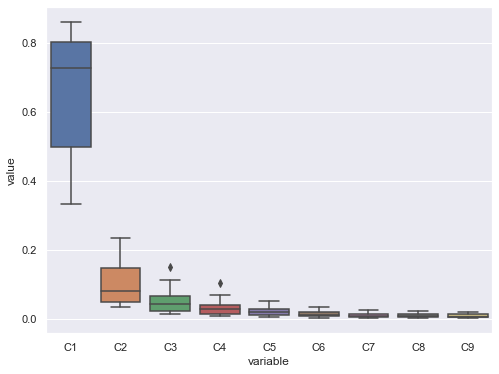

In [43]:
sns.boxplot(x="variable", y="value", data=pd.melt(pca_fpfh_df))

plt.show()

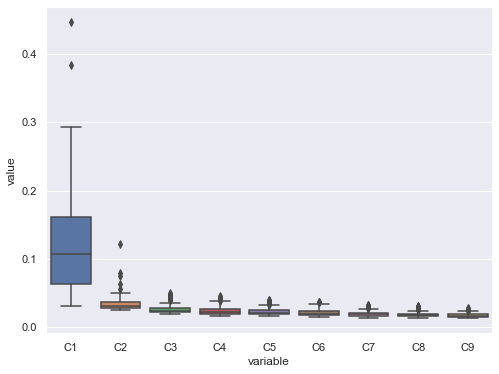

In [50]:
sns.boxplot(x="variable", y="value", data=pd.melt(pca_shot_main_df))

plt.show()

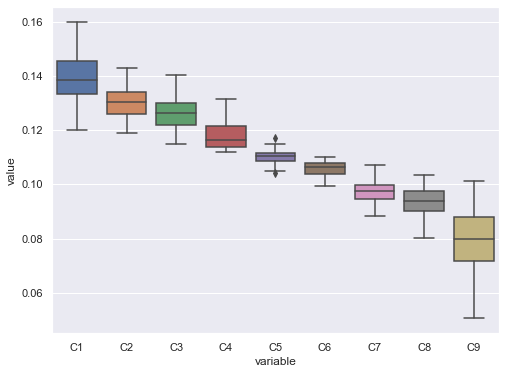

In [51]:
sns.boxplot(x="variable", y="value", data=pd.melt(pca_shot_rf_df))

plt.show()

In [482]:
pcl.io.savePLYFileASCII(file_name = os.path.join(OUTPUT_TEMP_PATH,f"{P_ID}{DESC_1_FILENAME}"), cloud = fpfh_desc)
pcl.io.savePLYFileASCII(file_name = os.path.join(OUTPUT_TEMP_PATH,f"{P_ID}{DESC_2_FILENAME}"), cloud = shot_desc)

0

In [506]:
fp_pcl = PlyData.read(os.path.join(OUTPUT_TEMP_PATH,f"{P_ID}{DESC_1_FILENAME}"), mmap=False)
sh_pcl = PlyData.read(os.path.join(OUTPUT_TEMP_PATH,f"{P_ID}{DESC_2_FILENAME}"), mmap=False)


In [551]:
fp_pcl.elements[0].properties 

(PlyListProperty('fpfh', 'uint', 'float'),)

In [552]:
sh_pcl.elements[0].properties 

(PlyListProperty('shot', 'uint', 'float'),
 PlyListProperty('rf', 'uint', 'float'))

In [508]:
fp_pcl.elements[0].data.dtype.descr , sh_pcl.elements[0].data.dtype.descr , 

([('fpfh', '|O')], [('shot', '|O'), ('rf', '|O')])

In [ ]:
# p.elements[0].properties = (PlyProperty('x', 'f4'), PlyProperty('y', 'f4'), PlyProperty('z', 'f4'))
# pl_wr = PlyData(p.elements, text = True, comments = ['PLYFILE BINARY TO ASCII CONVERTED IN float32'])
# pl_wr.write(os.path.join(OUTPUT_TEMP_PATH,f"{P_ID}{PYMESH_FILENAME}"))

In [505]:
P_ID

'32_JM'

In [512]:
curv_df = pd.read_csv(os.path.join(OUTPUT_TEMP_PATH,f"{P_ID}{CURV_FILENAME}"))
curv_df.head(2)

,x,y,z,mean_curv,gauss_curv
0,0.012883,-0.159311,-0.132606,0.000064,26.533195
1,0.012454,-0.158857,-0.133444,0.000032,-0.053352


In [517]:
curv_df['mean_curv'].values

array([ 6.445e-05,  3.185e-05,  7.893e-05, ...,  4.450e-06,  1.810e-06,
       -1.480e-06])

In [550]:
fpfh_desc.histogram.tolist()

[[2.9215550422668457,
  3.247018575668335,
  5.613362789154053,
  8.71410846710205,
  11.109100341796875,
  29.86857795715332,
  17.859872817993164,
  7.546583652496338,
  5.764786243438721,
  3.7187607288360596,
  3.63627552986145,
  10.111320495605469,
  6.462610721588135,
  13.483861923217773,
  6.200162410736084,
  5.5630364418029785,
  9.981301307678223,
  10.262409210205078,
  7.784458637237549,
  9.575860977172852,
  8.205789566040039,
  12.369195938110352,
  12.77844524383545,
  9.115850448608398,
  8.917832374572754,
  9.90579891204834,
  12.32900619506836,
  2.460315704345703,
  7.325277805328369,
  10.580820083618164,
  9.459003448486328,
  10.155712127685547,
  6.9719414710998535],
 [9.748515129089355,
  4.155381679534912,
  7.365167617797852,
  9.387524604797363,
  12.717202186584473,
  24.893892288208008,
  11.613490104675293,
  6.341095447540283,
  7.225144386291504,
  2.7371153831481934,
  3.815472364425659,
  21.43637466430664,
  5.475954532623291,
  8.013322830200195,

In [ ]:
plydata.elements[0].properties = (PlyProperty('x', 'f4'), PlyProperty('y', 'f4'), PlyProperty('z', 'f4'))

In [575]:
p = PlyData.read(os.path.join(OUTPUT_TEMP_PATH,f"{P_ID}{PYMESH_FILENAME}"))
v = p.elements[0]
f = p.elements[1]

# Create the new vertex data with a new name with required dtype
a = np.empty(len(v.data), v.data.dtype.descr 
             +[('mean_curv','f4')] 
             + [('gauss_curv','f4')] + [('fpfh', '|O')] 
             + [('shot', '|O')] + [('rf', '|O')]
            )

for name in v.data.dtype.fields:
    #re-assign
    a[name] = v[name]
# a['label'] = [np.array([1,2,19]),np.array([1,2,1]),np.array([11,22,19]),np.array([15,12,1])]
a['mean_curv'] = curv_df['mean_curv'].values
a['gauss_curv'] = curv_df['gauss_curv'].values

a['fpfh'] = fpfh_desc.histogram.tolist()
a['shot'] = shot_desc.descriptor.tolist()
a['rf'] = shot_desc.rf.tolist()

# Recreate the PlyElement instance
# v = PlyElement.describe(a, 'vertex')
#Redefine properties
# v.properties =  (PlyProperty('x', 'f4'), PlyProperty('y', 'f4'), PlyProperty('z', 'f4'), PlyListProperty('fpfh', 'uint', 'float'),)

# # Recreate the PlyData instance
# p = PlyData([v, f], text=True)


vert = PlyElement.describe(a, 'vertex')
vert.properties = v.properties + (PlyProperty('mean_curv', 'f4'),
                                  PlyProperty('gauss_curv', 'f4'),
                                  PlyListProperty('fpfh', 'uint', 'float'),
                                  PlyListProperty('shot', 'uint', 'float'), 
                                  PlyListProperty('rf', 'uint', 'float'),
                                 )
# Recreate the PlyData instance
p = PlyData([vert, f], text=True)



p.write((os.path.join(OUTPUT_PATH,f"{P_ID}_output.ply")))

In [572]:
vert.properties + (PlyListProperty('shot', 'uint', 'float'), PlyListProperty('rf', 'uint', 'float'),)

(PlyProperty('x', 'float'),
 PlyProperty('y', 'float'),
 PlyProperty('z', 'float'),
 PlyListProperty('fpfh', 'uint', 'float'),
 PlyListProperty('shot', 'uint', 'float'),
 PlyListProperty('rf', 'uint', 'float'))

In [545]:
[[1,2,19],[1,2,1],[11,22,19],[15,12,1]]

[[1, 2, 19], [1, 2, 1], [11, 22, 19], [15, 12, 1]]

In [544]:
arr = np.array([[1,2,19],[1,2,1],[11,22,19],[15,12,1]])
arr

array([[ 1,  2, 19],
       [ 1,  2,  1],
       [11, 22, 19],
       [15, 12,  1]])

In [546]:
arr.tolist()

[[1, 2, 19], [1, 2, 1], [11, 22, 19], [15, 12, 1]]

### File Concatenation
1. https://github.com/dranjan/python-plyfile/issues/26 
2. https://github.com/dranjan/python-plyfile/issues/15 

In [547]:
p = PlyData.read(os.path.join(OUTPUT_TEMP_PATH,"tet.ply"))
v = p.elements[0]
f = p.elements[1]

# Create the new vertex data with a new name with required dtype
a = np.empty(len(v.data), v.data.dtype.descr + [('label', '|O')])
for name in v.data.dtype.fields:
    #re-assign
    a[name] = v[name]
# a['label'] = [np.array([1,2,19]),np.array([1,2,1]),np.array([11,22,19]),np.array([15,12,1])]
# a['label'] = [[1,2,19],[1,2,1],[11,22,19],[15,12,1]]
a['label'] = arr.tolist()

# a['label'][0] = 123
# a['label'][1] = 126
# a['label'][2] = 129
# a['label'][3] = 121

# Recreate the PlyElement instance
v = PlyElement.describe(a, 'vertex')

# Recreate the PlyData instance
p = PlyData([v, f], text=True)

p.write((os.path.join(OUTPUT_TEMP_PATH,"test2.ply")))

In [176]:
v.data.dtype.fields

mappingproxy({'x': (dtype('float32'), 0),
              'y': (dtype('float32'), 4),
              'z': (dtype('float32'), 8),
              'label': (dtype('int32'), 12)})

In [180]:
p = PlyData.read(os.path.join(OUTPUT_TEMP_PATH,"tet.ply"))
v = p.elements[0]
f = p.elements[1]

# Create the new vertex data with a new name with required dtype
a = np.empty(len(v.data), v.data.dtype.descr + [('label', 'i4')])
for name in v.data.dtype.fields:
    #re-assign
    a[name] = v[name]



In [181]:
a

array([(0., 0., 0., 123), (0., 1., 1., 126), (1., 0., 1., 129),
       (1., 1., 0., 121)],
      dtype=[('x', '<f4'), ('y', '<f4'), ('z', '<f4'), ('label', '<i4')])

In [168]:
v.data.dtype.descr + [('label', 'i4')]

[('x', '<f4'), ('y', '<f4'), ('z', '<f4'), ('label', 'i4')]

In [538]:
test_fpfh = PlyData.read(os.path.join(OUTPUT_TEMP_PATH,"test_fpfh.ply"))
v = p.elements[0]

In [539]:
test_fpfh.elements[0].data.dtype.descr

[('fpfh', '|O')]

In [183]:
a['label']

array([123, 126, 129, 121])

In [540]:
test_fpfh.elements[0].data

array([(array([84.14448  ,  0.       ,  0.       ,  0.       ,  2.3670673,
       13.488455 ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       , 84.14448  ,  0.       ,  0.       ,  2.3670673,
        8.992304 ,  0.       ,  0.       ,  2.1290843,  2.3670673,
        0.       ,  0.       , 68.52694  ,  0.       ,  0.       ,
        0.       ,  2.3670673, 13.488455 ,  8.516337 ,  7.1012025,
        0.       ,  0.       ,  0.       ], dtype=float32),),
       (array([100.       ,   0.       ,   0.       ,   0.       ,   0.       ,
         0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
         0.       , 100.       ,   0.       ,   0.       ,   0.       ,
         0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
         0.       ,   0.       ,  86.40641  ,   0.       ,   0.       ,
         0.       ,   3.3983986,   6.7967973,   3.3983986,   0.       ,
         0.       ,   0.       ,   0.       ], dtype=float32),),
       (array([100.,   

In [583]:
import itertools 
a = [[1,2,5],[1,5,6],[1,6,7]]

In [584]:
[sum(x)/len(x) for x in zip(*a)]

[1.0, 4.333333333333333, 6.0]

In [607]:
x = [1,9,10]
y = [1,23,4]

z = list(zip(x,y))
z = z+[(2,5)]
z

[(1, 1), (9, 23), (10, 4), (2, 5)]

In [597]:
list(zip(*zip(x,y)))

[(1, 9, 10), (1, 23, 4)]

In [611]:
from itertools import zip_longest
z = [[1,2,5],[1,5,5,8,9,6],[1,6,3,7]]
# a = [y for x in z for y in x]
a = [x for x in zip_longest(*z)]
a

[(1, 1, 1),
 (2, 5, 6),
 (5, 5, 3),
 (None, 8, 7),
 (None, 9, None),
 (None, 6, None)]

In [647]:
b = [[z for z in x if z is not None] for x in a ]
b

[[1, 1, 1], [2, 5, 6], [5, 5, 3], [8, 7], [9], [6]]

In [650]:
[sum(x)/len(x) for x in b]

[1.0, 4.333333333333333, 4.333333333333333, 7.5, 9.0, 6.0]

In [652]:
sum([1,2])

3

In [658]:
"9" in "2353361"

False

In [678]:
x = [1,2,1,[1,2],[1,[2,4],[],2],9,10]
type(x[1])

int

In [665]:
def cal_avg(l):
    for a in range(x):
        if type(x[a]) == list and len(x[a])>0:
            x[a] = cal_avg(x[a])
        else:
            

True

In [677]:
sum([2,4])/len([2,4])

3.0

In [679]:
len([])

0